# Aerial images preprocessing with fiducial markers

The aerial preprocessing is highly inspired of [friedrichknuth/hipp](https://github.com/friedrichknuth/hipp) and this notebook use the same dataset as the [image restitution notebook](https://github.com/friedrichknuth/hipp/blob/master/examples/image_restitution/notebook.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hipp
import os
import glob
import pandas as pd

## Settings

In [3]:
# path settings
PROJECT_DIRECTORY = "data/aerial/"
RAW_IMAGES_DIRECTORY = os.path.join(PROJECT_DIRECTORY, "raw_images")
PREPROCESSED_IMAGES_DIRECTORY = os.path.join(PROJECT_DIRECTORY, "preprocessed_images")
FIDUCIALS_DIRECTORY = os.path.join(PROJECT_DIRECTORY, "fiducial_templates")
QC_DIRECTORY = os.path.join(PROJECT_DIRECTORY, "qc")

DETECTED_FIDUCIALS_PATH = os.path.join(RAW_IMAGES_DIRECTORY, "detected_fiducial_markers.csv")
TF_DETECTED_FIDUCIALS_PATH = os.path.join(PREPROCESSED_IMAGES_DIRECTORY, "detected_fiducial_markers.csv")

CAMERA_MODEL_PATH = os.path.join(PROJECT_DIRECTORY, "camera_model_intrinsics.csv")

# others settings
QUICKVIEWS_FACTOR = 0.2
MAX_WORKERS = 8

## Downloading the dataset

The dataset consists of 41 images of the South Cascade Glacier acquired on September 6, 1994.
The total download size is approximately 17 GB, but after GDAL optimization, the entire dataset occupies only around 9 GB on disk.

In [4]:
images_metadata = os.path.join(PROJECT_DIRECTORY, "1994_06_09_aerial_scg.csv")

if not os.path.exists(RAW_IMAGES_DIRECTORY):
    hipp.dataquery.NAGAP_download_images_to_disk(images_metadata, RAW_IMAGES_DIRECTORY)

# generate quick views of tif images with 20% resolution in .jpg
hipp.tools.generate_quickviews(RAW_IMAGES_DIRECTORY, factor=QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS)

Generating quickviews: 100%|██████████| 41/41 [00:15<00:00,  2.65image/s]


## Step 1 : Creation of midside fiducial template

- Choose an example image from the downloaded set (here we take the first image)
- `hipp.aerial.create_fiducial_templates()`
    - will launch an `opencv2` window to interactively select the midside fiducial marker center (with `Ctrl + Click`).
    - will enhance the resolution of the template for matching at subpixel accuracy.
    - will launch an other `opencv2` window of the enhanced template to select the exact center of the fiducial. The matching routine implemented below first performs a coarse template matching, then refines the position using the subpixel template.

**Note** :
For reproducibility, `hipp.aerial.create_fiducial_templates()` returns:
- The coarse coordinate of the fiducial.
- The subpixel-refined coordinate of the fiducial center.

If you already have these coordinates (e.g., saved from a previous run), you can pass them to the function to skip manual clicks entirely.


In [5]:
first_image_path = sorted(glob.glob(os.path.join(RAW_IMAGES_DIRECTORY, "*.tif")))[0]
saved_coords_midside = {'fiducial_coordinate': (1040, 5881), 'subpixel_center_coordinate': (803, 803)}

_ = hipp.aerial.create_fiducial_templates(first_image_path, FIDUCIALS_DIRECTORY, midside=True, **saved_coords_midside) 

## Step 2 : Creation of corner fiducial template

repeat the same steps above for corner fiducials.

In [6]:
first_image_path = sorted(glob.glob(os.path.join(RAW_IMAGES_DIRECTORY, "*.tif")))[0]
saved_coords_corner = {'fiducial_coordinate': (1115, 381), 'subpixel_center_coordinate': (805, 803)}

_ = hipp.aerial.create_fiducial_templates(first_image_path, FIDUCIALS_DIRECTORY, corner=True, **saved_coords_corner) 

Before starting the next step make sure to have correct fiducials templates.

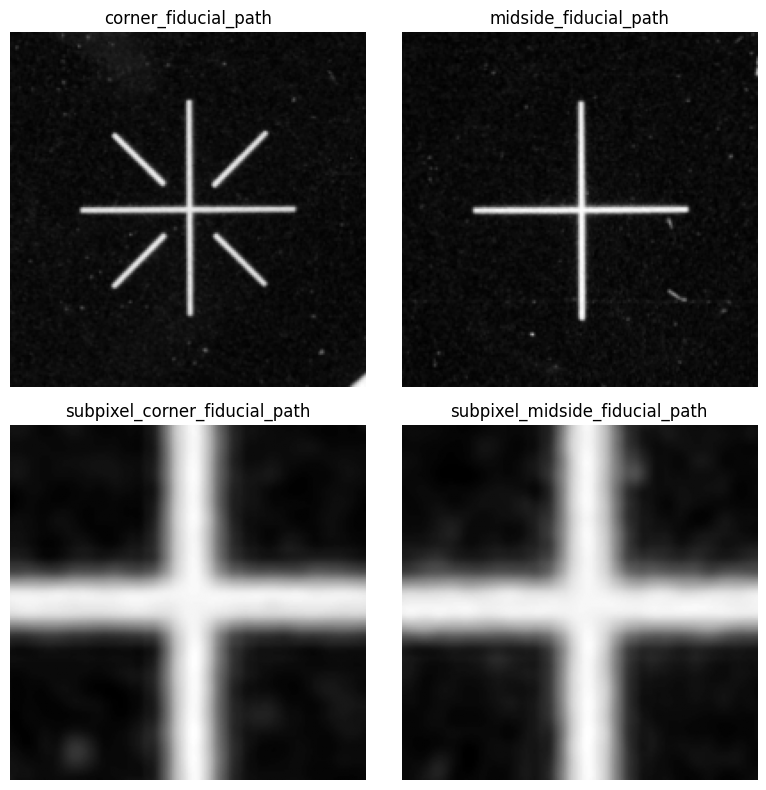

In [7]:
hipp.aerial.qc.plot_fiducial_templates(FIDUCIALS_DIRECTORY)

## Step 3 : fiducials detection and filter outliers

The `hipp.aerial.iter_detect_fiducials()` function will detect for all images in the raw images directory, midside fiducials and/or corner fiducials. To work, the method will call for each raw image the function `hipp.aerial.core.detect_fiducials` wich perform the following steps:
- grid the image into a n x n blocks (where n is the parameters `grid_size`).
- if both corner_fiducial and supixel_corner_fiducial exists:
    - perform coarse template matching on the 4 corner blocks
    - refine the position using the supixel_corner_fiducial
- if both midside_fiducial and supixel_midside_fiducial exists:
    - perform coarse template matching on the 4 midside blocks
    - refine the position using the supixel_corner_fiducial
- compute principal point using all detected fiducials

**Note** : 
- this function use multi-threading
- the `grid_size` need to be an **odd number**, and should be chosen such that all fiducials fall within the expected grid layout for accurate detection.

The `hipp.aerial.filter_detected_fiducials()` will filters out false positives based on two criteria:

- **Geometric Consistency:** Calculates angles between fiducials, validating those close to 90°, assuming a square fiducial pattern.
- **Matching Score Thresholding:** Compares the score of each match to the median score and keeps only those with a certain threshold 

After filtering the principal point is compute using valid diagonal.


In [ ]:

detected_fiducials_df = hipp.aerial.iter_detect_fiducials(RAW_IMAGES_DIRECTORY, FIDUCIALS_DIRECTORY, grid_size=7, max_workers=MAX_WORKERS)

filtered_detected_fiducials_df = hipp.aerial.filter_detected_fiducials(detected_fiducials_df)
filtered_detected_fiducials_df.round(2).to_csv(DETECTED_FIDUCIALS_PATH)

Fiducial detections: 100%|██████████| 41/41 [00:15<00:00,  2.58Image/s]


## [Optional] Control the Quality of the Detection

- `hipp.aerial.qc.generate_detection_qc_plots`  
  Generates an individual image or plot for each detection.  
  This function may take some time to run, but it can be useful in specific cases for detailed inspection.

- `hipp.aerial.qc.plot_detection_score_boxplot`  
  Produces a boxplot showing the distribution of matching scores for each fiducial.  
  This is useful to detect major issues and identify outliers.  
  Ideally, the distributions should be tightly clustered around the median.

- `hipp.aerial.qc.plot_fiducials_filtering`  
  Displays the deviation of fiducial coordinates between images.  
  Due to image shifts and distortions, some deviation is expected.  
  However, extreme outliers (with very high deviation) may indicate detection errors.  
  This plot is a good indicator of whether outliers have been successfully removed by the filtering process.


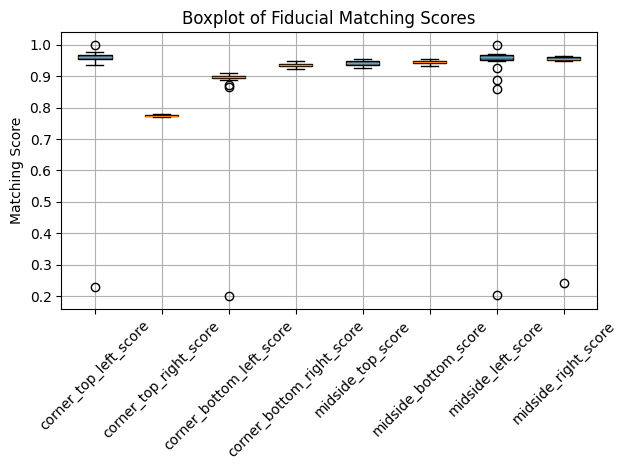

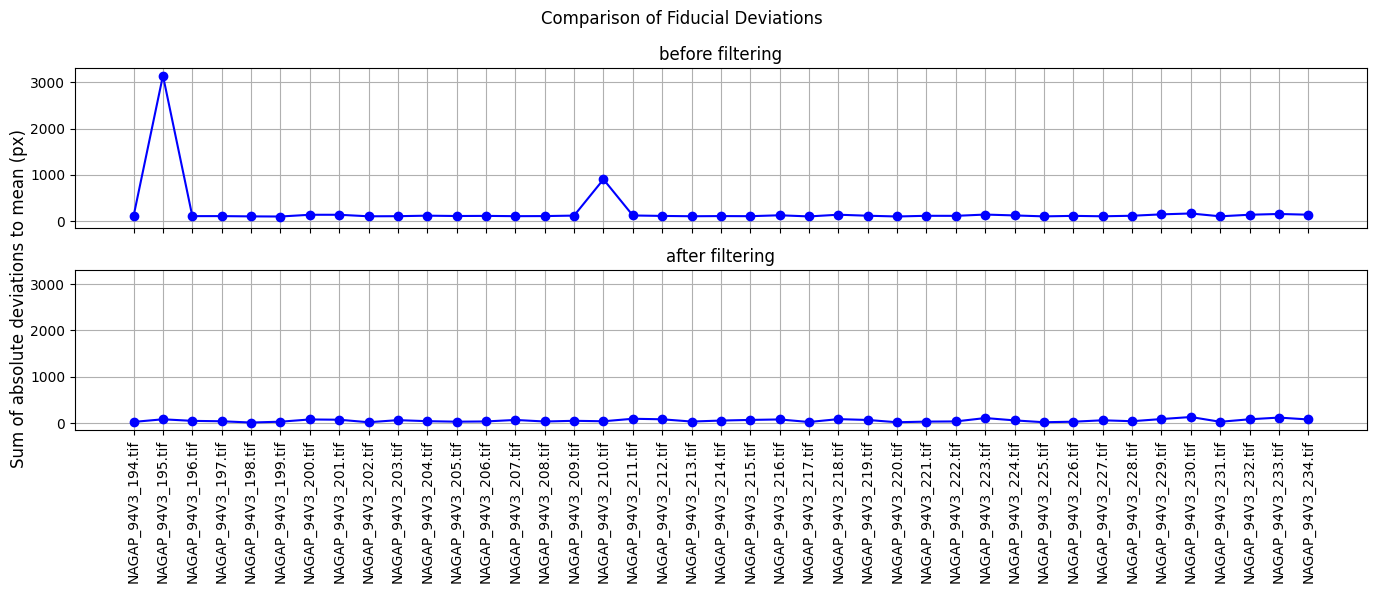

In [9]:
hipp.aerial.qc.generate_detection_qc_plots(RAW_IMAGES_DIRECTORY, detected_fiducials_df, output_directory=QC_DIRECTORY)
hipp.aerial.qc.plot_detection_score_boxplot(detected_fiducials_df)
hipp.aerial.qc.plot_fiducials_filtering(detected_fiducials_df, filtered_detected_fiducials_df)

## Step 6 : Prepare calibrated (true) fiducial marker coordinates

- Extract calibrated fiducial marker coordinate information from [calibration report](data/aerial/calibration_report.pdf), obtained via entering Camera Number, Lens Number, and Focal Length (printed on image frame) at https://fsapps.nwcg.gov/afm/cam/cam.php
- Extract scanning resolution
- Create a csv file with a structure similare to [`camera_model_intrinsics.csv`](data/aerial/camera_model_intrinsics.csv). 
- Open the csv file with `hipp.aerial.open_camera_model_intrinsics`.
- (Optional) Plot `true_fiducials_mm` to be sure your csv is correctly setup.

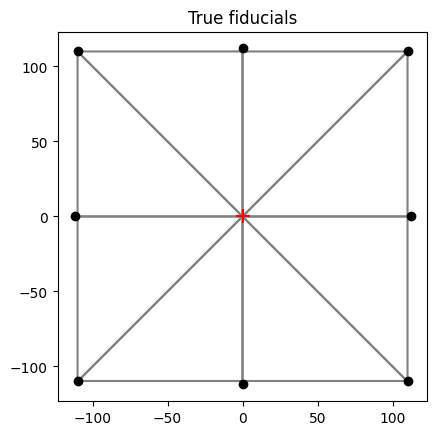

In [10]:
scanning_resolution_mm, true_fiducials_mm = hipp.aerial.open_camera_model_intrinsics(CAMERA_MODEL_PATH)

hipp.aerial.qc.plot_true_fiducials(true_fiducials_mm)

## Step 7 : Computing transformation

The goal here is to compute affine transformation matrix to restitute images by perfomring the following steps:
- convert the `true_fiducials_mm` in pixels ( / scanning_resolution_mm)
- translate `true_fiducials_pixels` for each computed principal point
- compute the appropriate geometric transformation to align true fiducials with detected fiducials based on the number of valid detected fiducials:
    - 1 point: Translation
    - 2 points: Similarity transformation
    - 3 or more points: Affine transformation
- compose the previously computed matrix with the translation necessary to crop the images with `image_square_dim` around the transformed principal point.


**Note** :
- If `true_fiducials_mm` is `None` the first transformation is skipped.
- If `image_square_dim` is `None` the crop is skipped.
- You can plot the difference of RMSE before and after the correction with the function `hipp.aerial.qc.plot_fiducials_correction`


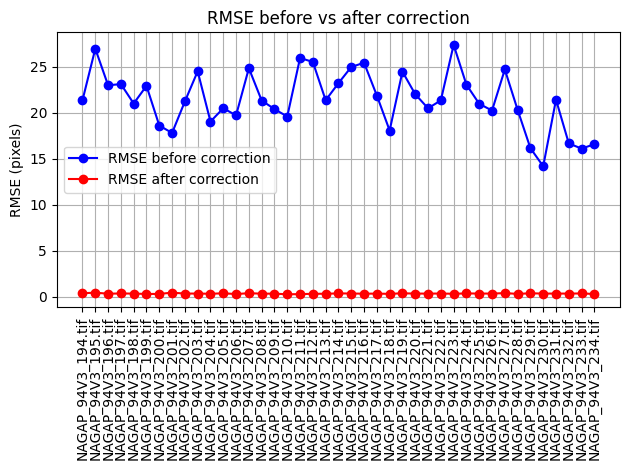

In [ ]:
df = pd.read_csv(os.path.join(RAW_IMAGES_DIRECTORY, "detected_fiducial_markers.csv"), index_col="image_id")
image_square_dim=10800

transformations = hipp.aerial.compute_transformations(df, true_fiducials_mm, image_square_dim, scanning_resolution_mm)

# save the transformed detected fiducial markers (coordinate of fiducials in preprocessed images)
os.makedirs(os.path.dirname(TF_DETECTED_FIDUCIALS_PATH), exist_ok=True)
hipp.aerial.warp_fiducials_df(df, transformations).round(2).to_csv(TF_DETECTED_FIDUCIALS_PATH)

# plot the correction to ensure it's correct
hipp.aerial.qc.plot_fiducials_correction(df, transformations, true_fiducials_mm, scanning_resolution_mm)

## Step 8: Image Restitution

`hipp.aerial.iter_image_restitution`  
Transforms all images in parallel by warping them using the previously computed transformation matrices.  
Each image is warped into an output window of size `image_square_dim`, with optional CLAHE enhancement applied.  
The resulting images are saved accordingly.

**Notes**:
- Uses **bi-cubic interpolation** by default for higher-quality resampling.
- Processing is done in **parallel** for better performance on large datasets.


In [12]:
hipp.aerial.iter_image_restitution(
    RAW_IMAGES_DIRECTORY, 
    PREPROCESSED_IMAGES_DIRECTORY, 
    transformations,
    image_square_dim=image_square_dim,
    max_workers=MAX_WORKERS
)
hipp.tools.generate_quickviews(PREPROCESSED_IMAGES_DIRECTORY, factor=QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS)

Generating quickviews: 100%|██████████| 41/41 [00:04<00:00,  8.40image/s]
